In [1]:
import keras
from keras import layers
import tensorflow as tf  # just for image processing and pipeline

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

2025-10-30 16:38:38.011113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True
)

num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

Dataset tf_flowers downloaded and prepared to /home/xy/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of training examples: 3303
Number of validation examples: 367


I0000 00:00:1761838748.052185   14656 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9026 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [3]:
# Reference: https://github.com/facebookresearch/FixRes/blob/main/transforms_v2.py.

batch_size = 32
auto = tf.data.AUTOTUNE
smaller_size = 128
bigger_size = 224

size_for_resizing = int((bigger_size / smaller_size) * bigger_size)
central_crop_layer = layers.CenterCrop(bigger_size, bigger_size)


def preprocess_initial(train, image_size):
    """Initial preprocessing function for training on smaller resolution.

    For training, do random_horizontal_flip -> random_crop.
    For validation, just resize.
    No color-jittering has been used.
    """

    def _pp(image, label, train):
        if train:
            channels = image.shape[-1]
            begin, size, _ = tf.image.sample_distorted_bounding_box(
                tf.shape(image),
                tf.zeros([0, 0, 4], tf.float32),
                area_range=(0.05, 1.0),
                min_object_covered=0,
                use_image_if_no_bounding_boxes=True,
            )
            image = tf.slice(image, begin, size)

            image.set_shape([None, None, channels])
            image = tf.image.resize(image, [image_size, image_size])
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, [image_size, image_size])

        return image, label

    return _pp


def preprocess_finetune(image, label, train):
    """Preprocessing function for fine-tuning on a higher resolution.

    For training, resize to a bigger resolution to maintain the ratio ->
        random_horizontal_flip -> center_crop.
    For validation, do the same without any horizontal flipping.
    No color-jittering has been used.
    """
    image = tf.image.resize(image, [size_for_resizing, size_for_resizing])
    if train:
        image = tf.image.random_flip_left_right(image)
    image = central_crop_layer(image[None, ...])[0]

    return image, label


def make_dataset(
    dataset: tf.data.Dataset,
    train: bool,
    image_size: int = smaller_size,
    fixres: bool = True,
    num_parallel_calls=auto,
):
    if image_size not in [smaller_size, bigger_size]:
        raise ValueError(f"{image_size} resolution is not supported.")

    # Determine which preprocessing function we are using.
    if image_size == smaller_size:
        preprocess_func = preprocess_initial(train, image_size)
    elif not fixres and image_size == bigger_size:
        preprocess_func = preprocess_initial(train, image_size)
    else:
        preprocess_func = preprocess_finetune

    dataset = dataset.map(
        lambda x, y: preprocess_func(x, y, train),
        num_parallel_calls=num_parallel_calls,
    )
    dataset = dataset.batch(batch_size)

    if train:
        dataset = dataset.shuffle(batch_size * 10)

    return dataset.prefetch(num_parallel_calls)

In [4]:
initial_train_dataset = make_dataset(train_dataset, train=True, image_size=smaller_size)
initial_val_dataset = make_dataset(val_dataset, train=False, image_size=smaller_size)

finetune_train_dataset = make_dataset(train_dataset, train=True, image_size=bigger_size)
finetune_val_dataset = make_dataset(val_dataset, train=False, image_size=bigger_size)

vanilla_train_dataset = make_dataset(
    train_dataset, train=True, image_size=bigger_size, fixres=False
)
vanilla_val_dataset = make_dataset(
    val_dataset, train=False, image_size=bigger_size, fixres=False
)

2025-10-30 16:39:37.560190: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


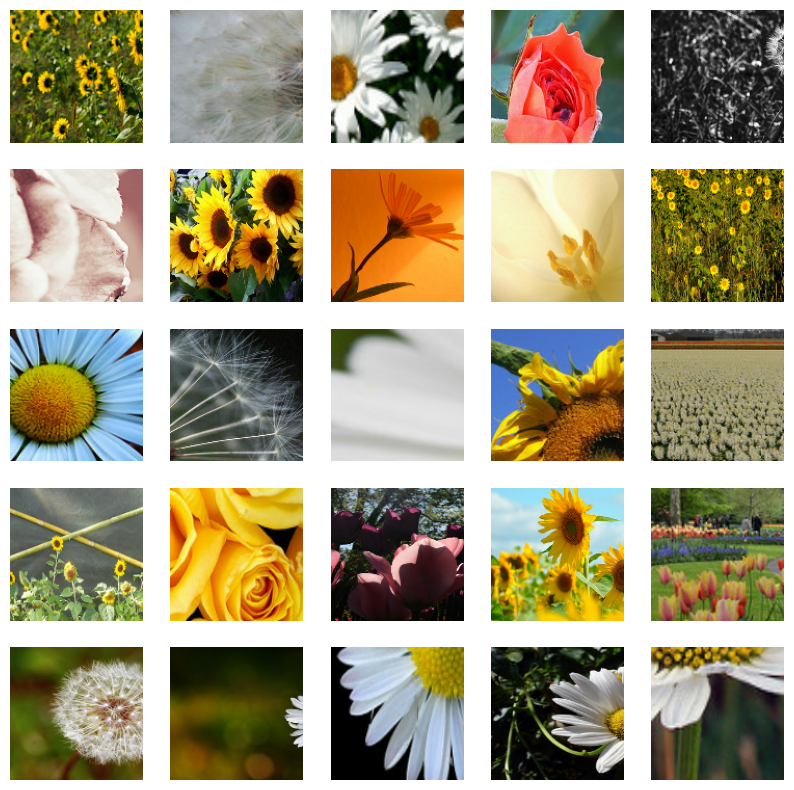

Batch shape: (32, 128, 128, 3).


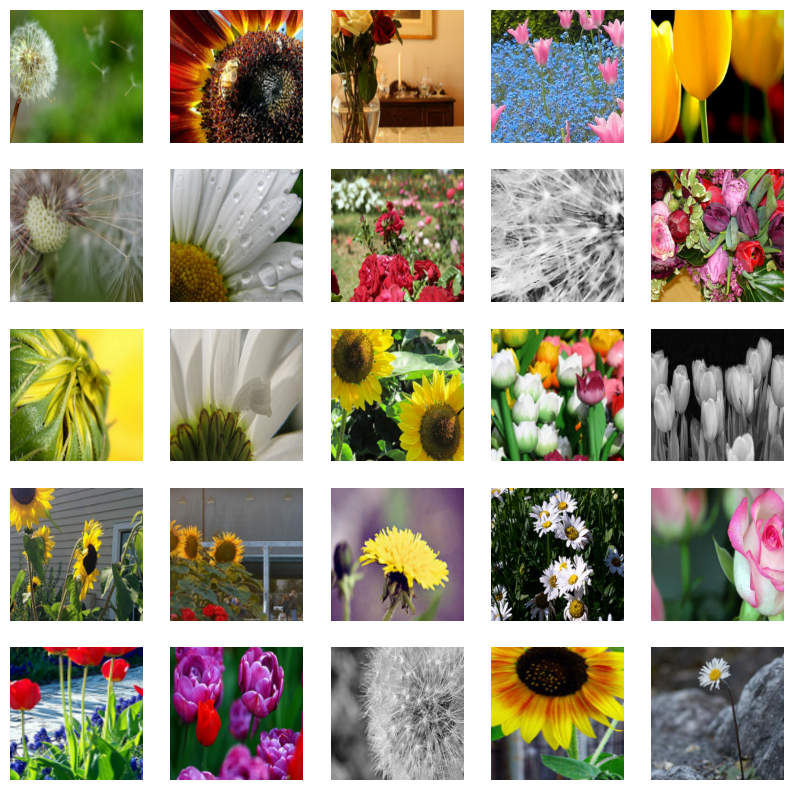

Batch shape: (32, 224, 224, 3).


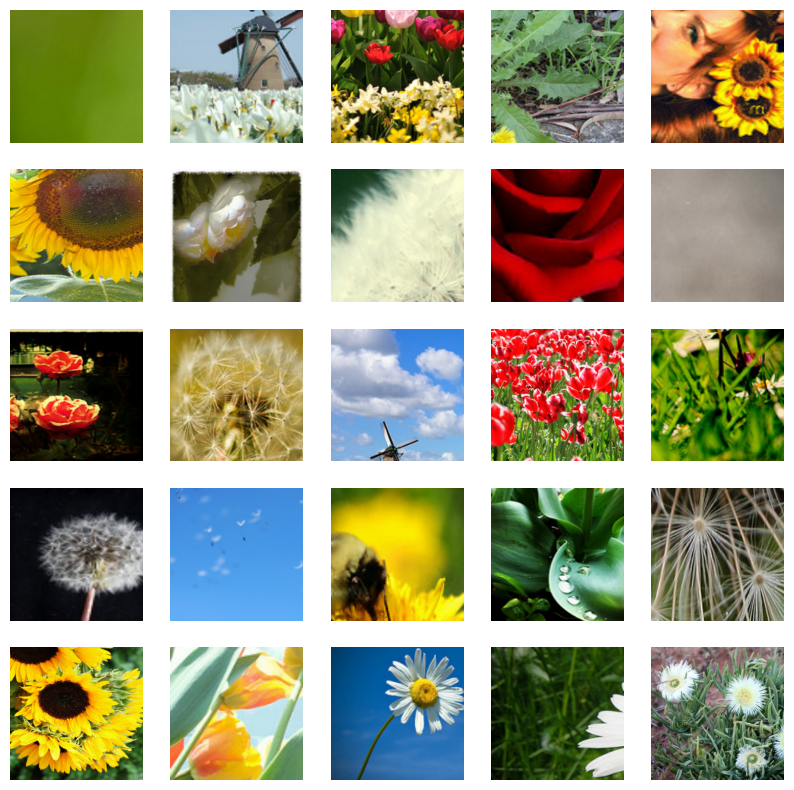

Batch shape: (32, 224, 224, 3).


In [5]:
def visualize_dataset(batch_images):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(batch_images[n].numpy().astype("int"))
        plt.axis("off")
    plt.show()

    print(f"Batch shape: {batch_images.shape}.")


# Smaller resolution.
initial_sample_images, _ = next(iter(initial_train_dataset))
visualize_dataset(initial_sample_images)

# Bigger resolution, only for fine-tuning.
finetune_sample_images, _ = next(iter(finetune_train_dataset))
visualize_dataset(finetune_sample_images)

# Bigger resolution, with the same augmentation transforms as
# the smaller resolution dataset.
vanilla_sample_images, _ = next(iter(vanilla_train_dataset))
visualize_dataset(vanilla_sample_images)

In [6]:
def get_training_model(num_classes=5):
    inputs = layers.Input((None, None, 3))
    resnet_base = keras.applications.ResNet50V2(
        include_top=False, weights=None, pooling="avg"
    )
    resnet_base.trainable = True

    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    x = resnet_base(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


def train_and_evaluate(
    model,
    train_ds,
    val_ds,
    epochs,
    learning_rate=1e-3,
    use_early_stopping=False,
):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    if use_early_stopping:
        es_callback = keras.callbacks.EarlyStopping(patience=5)
        callbacks = [es_callback]
    else:
        callbacks = None

    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
    )

    _, accuracy = model.evaluate(val_ds)
    print(f"Top-1 accuracy on the validation set: {accuracy*100:.2f}%.")
    return model

In [7]:
epochs = 30

smaller_res_model = get_training_model()
smaller_res_model = train_and_evaluate(
    smaller_res_model, initial_train_dataset, initial_val_dataset, epochs
)

Epoch 1/30


2025-10-30 16:40:23.404537: I external/local_xla/xla/service/service.cc:163] XLA service 0x7097f8002330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-30 16:40:23.404550: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-30 16:40:23.772183: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-30 16:40:26.161290: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


  3/104 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.1823 - loss: 2.7925

I0000 00:00:1761838835.357688   14781 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 186ms/step - accuracy: 0.4299 - loss: 1.4835 - val_accuracy: 0.2589 - val_loss: 1.7449
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.4929 - loss: 1.2813 - val_accuracy: 0.3624 - val_loss: 1.8320
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.5274 - loss: 1.1625 - val_accuracy: 0.5123 - val_loss: 1.4264
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5698 - loss: 1.0939 - val_accuracy: 0.4932 - val_loss: 1.4078
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.5964 - loss: 1.0520 - val_accuracy: 0.5749 - val_loss: 1.3260
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.6149 - loss: 1.0136 - val_accuracy: 0.5858 - val_loss: 1.3036
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.6258 - loss: 0.9977 - val_accuracy: 0.6594 - val_loss: 0.8300
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.6164 - loss: 0.9703 - val_accuracy: 0.6

In [8]:
for layer in smaller_res_model.layers[2].layers:
    layer.trainable = False

smaller_res_model.layers[2].get_layer("post_bn").trainable = True

epochs = 10

# Use a lower learning rate during fine-tuning.
bigger_res_model = train_and_evaluate(
    smaller_res_model,
    finetune_train_dataset,
    finetune_val_dataset,
    epochs,
    learning_rate=1e-4,
)

Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.7666 - loss: 0.6619 - val_accuracy: 0.7738 - val_loss: 0.6992
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7796 - loss: 0.6322 - val_accuracy: 0.7738 - val_loss: 0.6481
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7887 - loss: 0.6140 - val_accuracy: 0.7820 - val_loss: 0.6233
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7884 - loss: 0.6007 - val_accuracy: 0.7847 - val_loss: 0.6207
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7923 - loss: 0.5903 - val_accuracy: 0.7875 - val_loss: 0.6024
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7932 - loss: 0.5850 - val_accuracy: 0.7875 - val_loss: 0.5925
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7953 - loss: 0.5755 - val_accuracy: 0.7875 - val_loss: 0.5884
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7917 - loss: 0.5685 - val_ac

In [9]:
epochs = 30

vanilla_bigger_res_model = get_training_model()
vanilla_bigger_res_model = train_and_evaluate(
    vanilla_bigger_res_model, vanilla_train_dataset, vanilla_val_dataset, epochs
)

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 52s 272ms/step - accuracy: 0.4441 - loss: 1.4483 - val_accuracy: 0.2589 - val_loss: 1.6774
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.5144 - loss: 1.2184 - val_accuracy: 0.3079 - val_loss: 24.3653
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - accuracy: 0.5434 - loss: 1.1805 - val_accuracy: 0.4850 - val_loss: 1.7910
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.5707 - loss: 1.1031 - val_accuracy: 0.1935 - val_loss: 9.8238
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.5864 - loss: 1.0728 - val_accuracy: 0.6267 - val_loss: 0.9230
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.6082 - loss: 1.0099 - val_accuracy: 0.5804 - val_loss: 1.0615
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.6297 - loss: 0.9732 - val_accuracy: 0.5858 - val_loss: 1.1244
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.6197 - loss: 